<center> <h1>Thinning</h1> </center>

Simulate non homogeneous Poisson process.

## Required packages

In [162]:
import numpy as np
import math
from numpy.random import normal, uniform, poisson
import matplotlib.pyplot as pl

## Function for baseline

In [163]:
def f_Baseline(a,b,grille):
    lamb0 = np.zeros((grille.shape[0],))
    for k in np.arange(grille.shape[0]):
        lamb0[k] = (b**a)*a*(grille[k]**(a-1))
    return lamb0

## Time Varying Coefficients : $\beta(t)$

In [164]:
def beta_const(grille, param=1.):
    c = param
    beta_const = c*np.ones((grille.shape[0],))
    return beta_const
def beta_piecewise_const(grille, param=(4.,2.,1.)):
    c1,c2,rupture = param
    beta_2_const = c1*(grille<rupture)+c2*(grille>=rupture)
    return beta_2_const
def beta_linear(grille, param=(2.,-0.5)):
    ord_or,pente = param
    beta_lin = ord_or+pente*grille
    return beta_lin
def beta_quadratic(grille, param=(0.5)):
    a = param
    beta_quad = a*grille**2
    return beta_quad

## Time varying covariates : $X(t)$

Chaque X(k) suit une loi normale indépendante

In [238]:
def IndependantNormalX(n, p, grid, scaleX=0.5):
    X=[]
    n_points = grid.shape[0]
    for i in np.arange(n):
        X_i = np.vstack((normal(scale = scaleX, size = (p,n_points)).reshape(((p),n_points)))).T
        X.append(X_i)
    return X

## Brownian motion (Gaussian process)

In [370]:
def GaussianProcess(n, p, grid, start=0., mean=0., sd=1.):
    X=[]
    x_i = []
    n_points = grid.shape[0]
    for i in np.arange(n):
        last_x_i=normal(loc=mean+start, scale = sd, size = p)
        x_i_k = np.hstack(last_x_i)
        x_i = []
        #x_i.append(x_i_k)
        x_i = x_i_k
        #x_i = np.vstack((x_i,x_i_k))
        for k in range(len(grid)-1):
            increase = normal(loc=mean, scale = sd, size = p)
            x_i_k = x_i_k + increase
            #x_i.append(x_i_k)
            x_i = np.vstack((x_i,x_i_k))
        X.append(x_i)
    return X

In [382]:
GP = GaussianProcess(3, p=2, grid=grid, start=0., mean=0., sd=0.01)
GP

[array([[  5.26921739e-03,  -3.29239796e-03],
        [  1.26988267e-02,   6.31078244e-03],
        [  1.76659688e-02,   1.48305310e-02],
        [  6.49663816e-03,   2.25467352e-02],
        [  1.77061057e-03,   3.54528111e-02],
        [  3.00573591e-03,   3.85356072e-02],
        [ -5.00789750e-03,   2.60570304e-02],
        [  8.68480513e-03,   2.84367434e-02],
        [  2.74329867e-03,   2.10295747e-02],
        [  1.50698649e-02,   7.84969945e-03],
        [  2.27411645e-02,  -5.92943669e-03],
        [  1.81326931e-02,  -3.57781778e-03],
        [  6.17457240e-03,  -8.47619897e-03],
        [  7.06352554e-03,  -9.33058286e-03],
        [ -6.34447231e-03,  -3.76474043e-03],
        [ -1.26483881e-02,  -1.09542051e-02],
        [ -1.30736378e-02,  -5.43259470e-03],
        [ -9.86478016e-04,   1.68813149e-03],
        [ -1.27330089e-02,   7.37704460e-03],
        [ -2.01395310e-03,   4.18104347e-03],
        [ -4.55648791e-03,   7.63234125e-03],
        [  1.68022214e-03,  -4.611

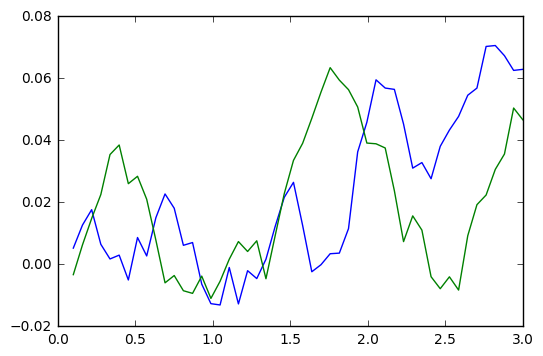

In [383]:
%matplotlib inline
pl.plot(grid, GP[0])

## $x_i(t) \beta(t)$

In [242]:
def f_xiBeta(X_i, beta, grid):
    n_i = X_i.shape[0]
    time_length = beta.shape[1]
    Xbeta_i=np.zeros(time_length)
    for t in np.arange(time_length):
        interval = 0
        condition = (grid[t] <= grid[0])
        while condition == False :
            interval += 1
            if interval < n_i:
                condition = (grid[t] <= grid[interval])
        if interval >= n_i:
                interval =n_i-1
                condition = True
        Xbeta_i[t]= np.dot(X_i[interval,:],beta[:,t])
    return Xbeta_i

## $\lambda_i(t) = \lambda_0(t) e^{X(t)\beta(t)}$

In [243]:
def lambda_i(baseline, X_i, beta, grid, nevents=1):
    Xbeta_i = f_xiBeta(X_i, beta, grid)
    lambda_i = nevents * baseline * np.exp(Xbeta_i)
    return lambda_i

In [244]:
## Thinning

In [245]:
def PPH(grid,C):
    t = np.max(grid)
    N_t = poisson(t*C)
    occurence = np.sort(uniform(0,t,N_t))
    return occurence

In [246]:
def thining_timevarying(baseline, X, beta, grid, nevents=1):
    n  = len(X)
    ppnh = []
    accept = []
    for i in np.arange(n):
        intensity_i = lambda_i(baseline, X[i], beta, grid, nevents)
        C = np.max(intensity_i)
        #print "nombre de points moyen", np.max(grid)*C
        Potential_Event = PPH(grid,C)
        N = len(Potential_Event)
        u = uniform(0,1,N)
        # find event intervall
        Potential_Event_Intervall = np.zeros(N)
        Potential_Event_Intensity = np.zeros(N)
        for j in range(N):
            for k in range(len(grid)):
                if grid[k] > Potential_Event[j]:
                    Potential_Event_Intervall[j] = k
                    Potential_Event_Intensity[j] = intensity_i[k]
                    break   
        #intensity_i = lambda_i(baseline, X[i], beta, Potential_Event_Intervall, nevents)
        probas = Potential_Event_Intensity/C
        accept = np.where(u <= probas)#.reshape((N,)))
        if len(accept[0]) == 0:
            # no event = event at t = infinity
            ppnh.append(np.array([math.inf]))
        else:    
            ppnh.append(Potential_Event[accept])
    return ppnh

## Simulations

In [384]:
n = 1000
p = 3
grid = np.linspace(0.1,3,num=50)
baseline = f_Baseline(1.,1.,grid)
beta = np.vstack([beta_piecewise_const(grid, param=(0.4,0.2,1.)),
                  beta_linear(grid, param=(1.,-0.5)),
                  beta_quadratic(grid, param=(0.15))])
X = IndependantNormalX(n=n, p=p, grid=grid, scaleX=0.5)
#X = GaussianProcess(n=n, p=p, grid=grid, start=1., mean=0., sd=0.0001)#1./(len(grid)))
%time NHPP = thining_timevarying(baseline, X, beta, grid, nevents=1)

Wall time: 4.76 s


In [294]:
#NHPP

In [295]:
#X

## Format data

In [376]:
s = np.array([])
for j in range(p):
    s = np.append(s,"x"+str(j+1))
data = np.array(["id", "event", "start", "stop"]+list(s))
start = np.array(np.append(0, grid[:-1]))
stop = grid
for i in range(n):
    event_time = NHPP[i][0] # only one event
    for k in range(len(grid)):
        if start[k]<=event_time and event_time<stop[k]:
            data_i_k = np.append([i, 1, start[k], event_time], X[i][k])
            data = np.vstack((data, data_i_k))
            break
        else :
            data_i_k = np.append([i, 0, start[k], stop[k]], X[i][k])
            data = np.vstack((data, data_i_k))

In [298]:
#data

## Write file

In [377]:
#nomfichier = "/data/simu_Gaussian_Process.csv"
nomfichier = "/data/simu_independent_Gaussian.csv"
currentdir = %pwd    
import pandas as pd
df = pd.DataFrame(data) 
print(df.shape)
df.to_csv(currentdir+nomfichier,header=False,index=False)

(4429, 7)


# Debug below

### Event time(s)

In [385]:
NHPP

[array([ inf]),
 array([ 2.11592846,  2.14988502,  2.9867778 ]),
 array([ 2.48835458]),
 array([ 1.38417945,  2.0220163 ,  2.55770548]),
 array([ 0.05975746,  1.18100649,  1.58090692,  1.87461988,  2.27220825,
         2.41818088,  2.48916804,  2.72139762,  2.97765646]),
 array([ 0.85849222,  1.62935151,  2.24755694,  2.87011211]),
 array([ 0.9776087 ,  1.86981728,  2.24719279,  2.63772249]),
 array([ 0.35403389,  0.48794929,  2.83387794]),
 array([ 2.17239991,  2.26070681,  2.40960927,  2.79064805]),
 array([ 0.56133802,  1.08472912,  2.40748128]),
 array([ 0.34788203,  1.00760651,  1.1559241 ,  2.49437361]),
 array([ 0.428288  ,  1.65432069,  1.82563139,  2.24551508]),
 array([ 0.53994694,  1.86972941]),
 array([ 2.28508238,  2.5419303 ]),
 array([ 0.35791932,  0.59475716,  1.17768832,  1.77284872,  1.78956759]),
 array([ 1.9624416 ,  2.70680226,  2.75405879]),
 array([ 0.28565438,  2.64084388]),
 array([ 2.55799904,  2.88899576,  2.90270665]),
 array([ 1.8430716 ,  2.35125928]),
 ar

In [388]:
np.mean(NHPP[:][0])

inf

In [387]:
np.std(NHPP[:][0])

C:\Users\tallart\AppData\Local\Continuum\Miniconda3\lib\site-packages\numpy\core\_methods.py:101: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


nan

### Plot baseline

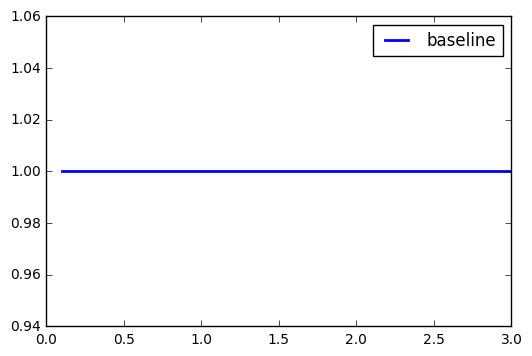

In [389]:
%matplotlib inline
pl.plot(grid, baseline, label="baseline", lw=2)
pl.legend()

### Plot coefficients

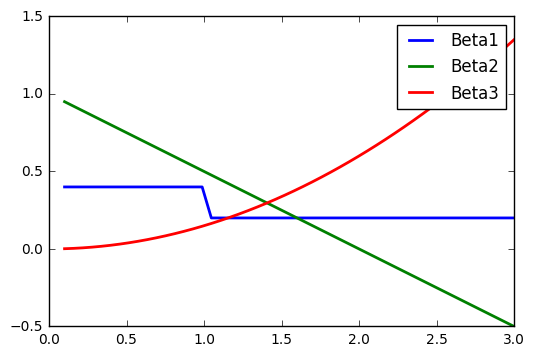

In [390]:
pl.axis([0, 3, -0.5, 1.5])
for j in range(len(beta)) :
    pl.plot(grid, beta[j], label="Beta" + str(j+1), lw=2)
pl.legend()

## Plot $x_i$

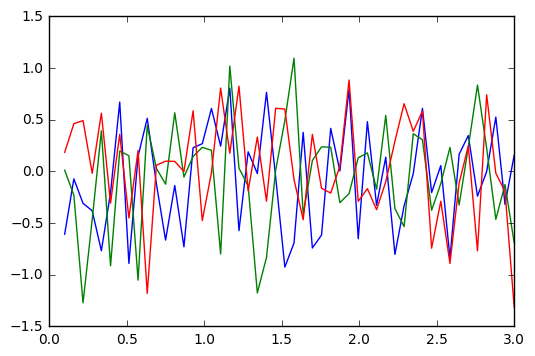

In [391]:
pl.plot(grid,X[0])

### Plot $x_i\beta$

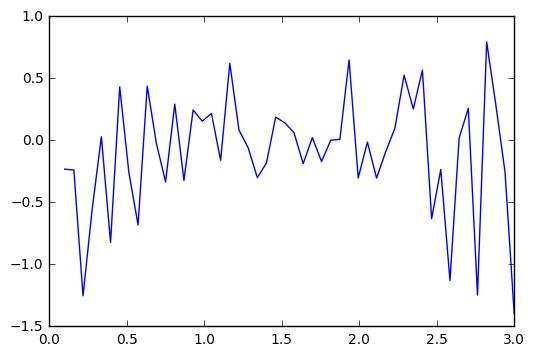

In [392]:
pl.plot(grid, f_xiBeta(X[0], beta, grid))

### Plot $e^{x_i\beta}$

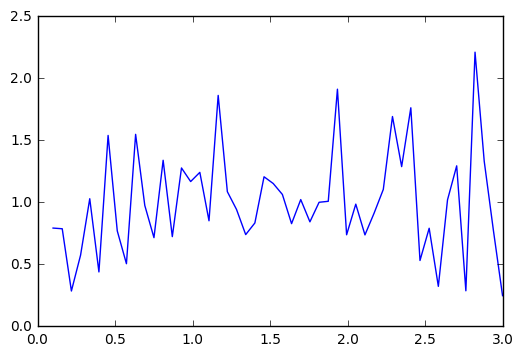

In [393]:
pl.plot(grid, np.exp(f_xiBeta(X[0], beta, grid)))

### plot $\lambda_i(t)$

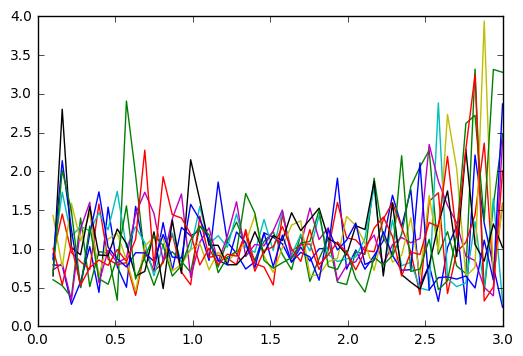

In [394]:
for i in range(min(n,10)):
    pl.plot(grid, lambda_i(baseline, X[i], beta, grid))